In [80]:
from pyrsgis import raster
from pyrsgis.convert import changeDimension
import math
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

import numpy as np
# from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten



input_bands = [i+1 for i in range(0,7)]
labels_band = 8
kSize = 7
nBands = len(input_bands)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:

# generate image chips for training CNN
def CNNdataGenerator(image, kSize):
    
    ds_features, features = raster.read(image, bands=input_bands) # if just inputting one band, do NOT put the single number in a list to pass to "bands", it causes some issue under the hood
    ds_labels, labels = raster.read(image, bands=labels_band)
    
    # remove outer edges of data (which sometimes have issues)
    features = diu.removeOuterEdges(features)
    labels = diu.removeOuterEdges(labels)

    # fill NaNs with 0s
    features = np.nan_to_num(features)
    labels = np.nan_to_num(labels)

    # normalize bands
    features = diu.normalizeUInt16Band(features)

    nBands, rows, cols = features.shape
    
    print(features.shape)
    
    margin = math.floor(kSize/2)
    features = np.pad(features, margin, mode='constant')[margin:-margin, :, :]
    
    features_training = np.empty((rows*cols, kSize, kSize, nBands))
#     labels_training = np.empty((rows*cols))

    n = 0
    for row in range(margin, rows+margin):
        for col in range(margin, cols+margin):
            feat = features[:, row-margin:row+margin+1, col-margin:col+margin+1]
            
#             print(feat.shape)

            b1, b2, b3, b4, b5, b6, b7 = feat
            feat = np.dstack((b1, b2, b3, b4, b5, b6, b7))

            features_training[n, :, :, :] = feat
            
#             labels_training = 
            
            n += 1
           
    labels = changeDimension(labels)    
    labels = (labels == 1).astype(int)

    return(features_training, labels)

In [68]:
features_training, labels = CNNdataGenerator("../SatelliteImages/Florida_1_2000.tif", kSize)
print(features_training.shape)
print(labels.shape)
      


(7, 445, 1855)
(825475, 7, 7, 7)
(825475,)


In [69]:
xTrain, xTest, yTrain, yTest = train_test_split(features_training, labels, test_size=0.4, random_state=42, stratify=labels, shuffle=True)


In [70]:
print(xTrain.shape)
print(xTest.shape)


(495285, 7, 7, 7)
(330190, 7, 7, 7)


In [82]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(kSize, kSize, nBands)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer= 'rmsprop',metrics=['accuracy'])
model.fit(xTrain, yTrain)

15478/15478 [==============================] - 89s 6ms/step - loss: 0.1164 - accuracy: 0.9534


Confusion matrix:
 [[222406   9548]
 [  2127  96109]]

P-Score: 0.910, R-Score: 0.978
Accuracy: 0.965
f1: 0.943
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    231954
           1       0.91      0.98      0.94     98236

    accuracy                           0.96    330190
   macro avg       0.95      0.97      0.96    330190
weighted avg       0.97      0.96      0.96    330190



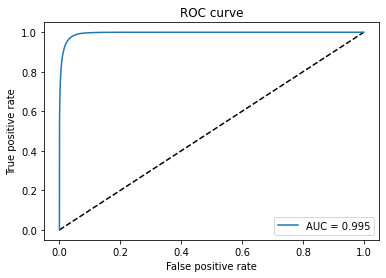

In [83]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob)